# Exploring TC-PRIMED
[TC-PRIMED](https://rammb-data.cira.colostate.edu/tcprimed/) is a recent dataset put together by the NOAA, the Colorado State University Department of Atmospheric Science, and other insitutions. It includes data centered on Tropical Cyclones, with the most notable features being:
* Satellite Microwave images
* Infrared images from the [RAMMB/CIRA archive](https://satlib.cira.colostate.edu/media-archive/) and [HURSAT-B1](https://www.ncei.noaa.gov/products/hurricane-satellite-data) dataset
* ERA5 environment fields
* Best-track data giving TC characteristics.
* GPROF-estimated precipitations
* Satellite radar precipitations fields.

In this notebook, we'll explore the subset of TC-PRIMED corresponding to the year 2017, which already includes 51GB of data. We'll focus only the Atlantic (AL) basin.  
Note: the awesome authors of TC-PRIMED included a series of [tutorial notebooks](https://nbviewer.org/github/CSU-CIRA/tcprimed_learning_journey/tree/main/) on using TC-PRIMED. Moreover, the documentation is available at [this link](https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/TCPRIMED_v01r00_documentation.pdf).

# Imports and environment

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from netCDF4 import Dataset
from pathlib import Path

The dataset tree has the format ```root_dir/BASIN/XX/files.nc``` where ```XX``` is the number (starting at 01) of the storm during the season.

In [3]:
_TC_PRIMED_PATH_ = Path("data/raw/tc_primed/2017/AL/12/")

# Single storm overpass file
We'll now load an entry from a single storm of the 2017 season.

In [4]:
storm_files = [_TC_PRIMED_PATH_ / file for file in os.listdir(_TC_PRIMED_PATH_) if "era5" not in str(file)]
dataset = Dataset(storm_files[10])
print("Found keys ", dataset.groups.keys())

Found keys  dict_keys(['overpass_metadata', 'overpass_storm_metadata', 'passive_microwave', 'GPROF', 'infrared'])


Let's look at the ```passive_microwave``` group:

In [5]:
dataset['passive_microwave']

<class 'netCDF4._netCDF4.Group'>
group /passive_microwave:
    title: NASA inter-calibrated satellite passive microwave brightness temperature fields
    source: 1C.F16.SSMIS.XCAL2021-V.20170910-S192532-E210726.071709.V07A.HDF5
    comment: NASA inter-calibrated satellite passive microwave brightness temperature fields version V07A from the Precipitation Processing System (PPS), National Aeronautics and Space Administration (NASA). doi:10.5067/GPM/SSMIS/F16/1C/07
    references: Berg, W., and Coauthors, 2016: Intercalibration of the GPM microwave radiometer constellation. J. Atmos. Oceanic Technol., 33, 2639-2654, doi:10.1175/JTECH-D-16-0100.1.
    keywords: EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > SUBSETTING/SUPERSETTING, EARTH SCIENCE > SPECTRAL/ENGINEERING > MICROWAVE > BRIGHTNESS TEMPERATURE, EARTH SCIENCE > ATMOSPHERE > WEATHER EVENTS > TROPICAL CYCLONES
    keywords_vocabulary: GCMD:GCMD Keywords
    standard_name_vocabulary: CF Standard Name Table v77
    process

The group includes four sub-groups: ```S1``` to ```S4```. This is because the ```SSMIS``` sensor includes four swaths. Each swatch has its own set of available frequencies and polarizations.

In [6]:
pmw = dataset['passive_microwave']
pmw['S1']

<class 'netCDF4._netCDF4.Group'>
group /passive_microwave/S1:
    title: NASA inter-calibrated satellite passive microwave brightness temperature fields for the S1 swath
    cdm_data_type: Swath
    geospatial_lat_min: 8.7856
    geospatial_lat_max: 34.7164
    geospatial_lat_units: degrees_north
    geospatial_lon_min: 285.1316
    geospatial_lon_max: 306.8659
    geospatial_lon_units: degrees_east
    time_coverage_start: 2017-09-10T19:53:07.000Z
    time_coverage_end: 2017-09-10T19:58:32.000Z
    dimensions(sizes): scan(172), pixel(90)
    variables(dimensions): float32 latitude(scan, pixel), float32 longitude(scan, pixel), float64 x(scan, pixel), float64 y(scan, pixel), int16 angle_bins(pixel), int64 ScanTime(scan), float32 TB_19.35V(scan, pixel), float32 TB_19.35H(scan, pixel), float32 TB_22.235V(scan, pixel)
    groups: 

The brightness temperatures are contained in the variables ```TB_XX.XXXP``` where ```XX.XXX``` is a frequency and ```P``` can be H, V, QH and QV and is the polarization.  
Let's plot every TB variable from the first swath:

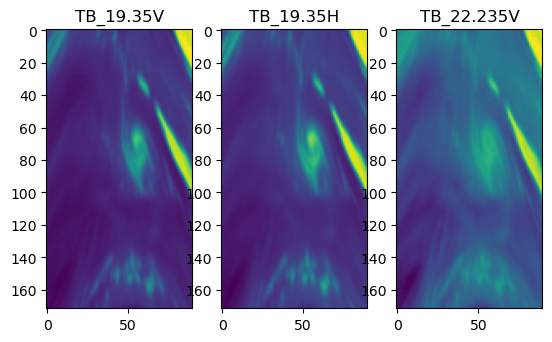

In [7]:
# Retrieve all 'TB_...' variables in the 'S1' subgroup
tb_vars = [var for var in list(pmw['S1'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S1'][var])
    ax.set_title(var)

Let's do the same for the third and fourth swath:

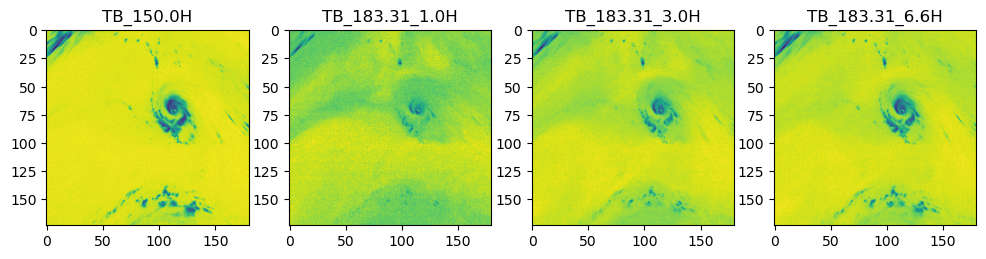

In [8]:
tb_vars = [var for var in list(pmw['S3'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars), figsize=(12, 4))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S3'][var])
    ax.set_title(var)

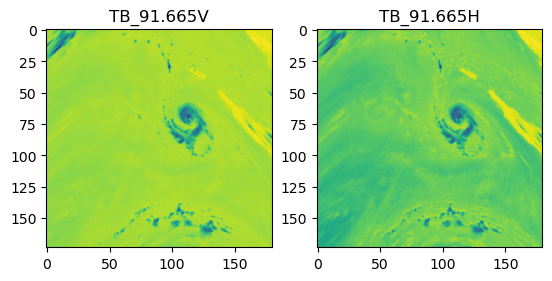

In [9]:
tb_vars = [var for var in list(pmw['S4'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S4'][var])
    ax.set_title(var)

Let's now look at the ```infrared``` group. The infrared image is only available when the ```infrared_availability_flag``` attribute is not zero.

In [10]:
dataset['infrared']['infrared_availability_flag'][:]

masked_array(data=[1],
             mask=False,
       fill_value=999999,
            dtype=int8)

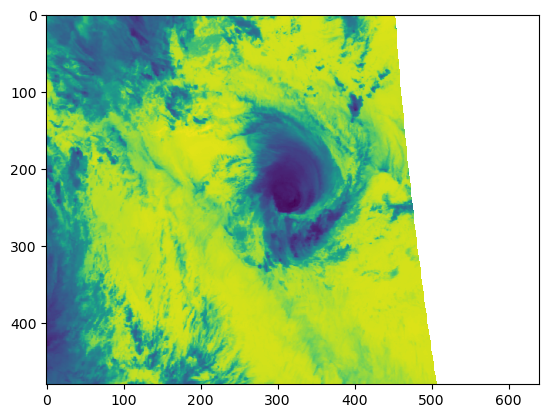

In [11]:
plt.imshow(dataset['infrared']['IRWIN'])

# Single storm environmental file
We'll now load the environmental file for the same storm as previously. The environmental file includes notably:
* ERA5 fields centered on the storm, and 20° degrees wide in each cardinal direction around it.
* SHIPS diagnostics derived from IR imagery.
The ```rectilinear``` group contains the ERA5 fields.

In [12]:
# Retrieve the environment file, which is the only one that contain "era5" in its filename.
env_file = [_TC_PRIMED_PATH_ / file for file in os.listdir(_TC_PRIMED_PATH_) if "era5" in str(file)][0]
env_dataset = xr.open_mfdataset([env_file], group="rectilinear")
env_dataset

<xarray.Dataset> Size: 395MB
Dimensions:              (time: 85, level: 21, ny: 81, nx: 81)
Coordinates:
  * time                 (time) datetime64[ns] 680B 2017-09-04T06:00:00 ... 2...
  * level                (level) int16 42B 100 150 200 250 ... 925 950 975 1000
Dimensions without coordinates: ny, nx
Data variables: (12/19)
    latitude             (time, ny) float32 28kB dask.array<chunksize=(1, 81), meta=np.ndarray>
    longitude            (time, nx) float32 28kB dask.array<chunksize=(1, 81), meta=np.ndarray>
    precipitable_water   (time, ny, nx) float32 2MB dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    rain_large_scale     (time, ny, nx) float32 2MB dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    rain_convective      (time, ny, nx) float32 2MB dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    sst                  (time, ny, nx) float32 2MB dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    ...                   ...
    specific_humidity    (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
    u_wind               (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
    v_wind               (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
    geopotential_height  (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
    vorticity            (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
    divergence           (time, level, ny, nx) float32 47MB dask.array<chunksize=(1, 21, 81, 81), meta=np.ndarray>
Attributes: (12/21)
    title:                         Storm-centric, rectilinear ECMWF ERA5 grids
    source:                        Contains modified Copernicus Atmosphere Mo...
    references:                    Copernicus Climate Change Service (C3S) (2...
    keywords:                      EARTH SCIENCE SERVICES > DATA MANAGEMENT/D...
    keywords_vocabulary:           GCMD:GCMD Keywords
    standard_name_vocabulary:      CF Standard Name Table v77
    ...                            ...
    geospatial_vertical_max:       1000
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     hPa
    time_coverage_resolution:      P0000-00-00T06:00:00
    time_coverage_start:           2017-09-04T06:00:00.000Z
    time_coverage_end:             2017-09-25T06:00:00.000Z

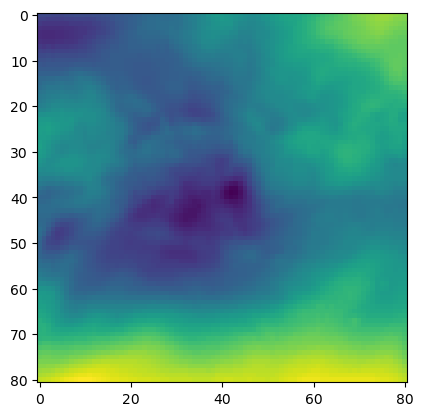

In [13]:
plt.imshow(env_dataset['geopotential_height'].sel(time=env_dataset.time[0]).sel(level=1000))

Let's have a look at the SHIPS diagnostics:

In [14]:
ships = xr.open_mfdataset([env_file], group="diagnostics")
ships

<xarray.Dataset> Size: 130kB
Dimensions:                          (time: 85, level: 21, bins: 5, region: 1,
                                      regions: 2, layer: 2)
Coordinates:
  * time                             (time) datetime64[ns] 680B 2017-09-04T06...
  * level                            (level) int16 42B 100 150 200 ... 975 1000
  * bins                             (bins) int16 10B 0 200 400 600 800
Dimensions without coordinates: region, regions, layer
Data variables: (12/37)
    number_radii                     int16 2B ...
    number_azimuths                  int16 2B ...
    delta_radius                     float32 4B ...
    delta_azimuth                    float32 4B ...
    center_latitude                  (time) float32 340B dask.array<chunksize=(85,), meta=np.ndarray>
    center_longitude                 (time) float32 340B dask.array<chunksize=(85,), meta=np.ndarray>
    ...                               ...
    u_wind                           (time, level, regions) float32 14kB dask.array<chunksize=(1, 21, 2), meta=np.ndarray>
    v_wind                           (time, level, regions) float32 14kB dask.array<chunksize=(1, 21, 2), meta=np.ndarray>
    t_wind                           (time, level, region) float32 7kB dask.array<chunksize=(1, 21, 1), meta=np.ndarray>
    geopotential_height              (time, level, region) float32 7kB dask.array<chunksize=(1, 21, 1), meta=np.ndarray>
    vorticity                        (time, level, region) float32 7kB dask.array<chunksize=(1, 21, 1), meta=np.ndarray>
    divergence                       (time, level, region) float32 7kB dask.array<chunksize=(1, 21, 1), meta=np.ndarray>
Attributes: (12/22)
    title:                         Storm-centric, area-averaged environmental...
    source:                        Contains modified Copernicus Atmosphere Mo...
    references:                    Slocum, C. J., M. N. Razin, J. A. Knaff, a...
    keywords:                      EARTH SCIENCE SERVICES > DATA MANAGEMENT/D...
    keywords_vocabulary:           GCMD:GCMD Keywords
    standard_name_vocabulary:      CF Standard Name Table v77
    ...                            ...
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     hPa
    time_coverage_resolution:      P0000-00-00T06:00:00
    comments:                      Values are calculated following procedures...
    time_coverage_start:           2017-09-04T06:00:00.000Z
    time_coverage_end:             2017-09-25T06:00:00.000Z